
# SVD klasifikator znamenki

### Učitavanje MNIST dataseta

(60000, 28, 28)
(10000, 28, 28)
(60000,)

Primjer znamenke za svaku klasu:


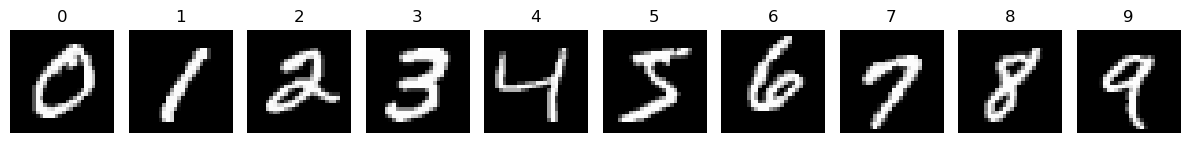

In [140]:
import numpy as np
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# --- Učitavanje ---
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train / 255.0).astype(np.float64)
x_test  = (x_test  / 255.0).astype(np.float64)

#ispis veličine trening/test skupa i veličine slika unutar njih
print(x_train.shape)
print(x_test.shape)

print(y_train.shape)

# --- Parametri ---
broj_klasa = 10
dim_slika = 28 * 28
broj_slika_po_klasi =  100 #mozda se moze i izbrisati
seed = 123  # za ponovljiv odabir

# Uzmemo prvi indeks za svaku klasu 0..9 iz x_train
print("\nPrimjer znamenke za svaku klasu:")
primjeri_idx = [np.where(y_train == c)[0][0] for c in range(broj_klasa)]

# Nacrtaj u jednom redu
fig, axes = plt.subplots(1, broj_klasa, figsize=(12, 1.8))
for i, c in enumerate(range(broj_klasa)):
    axes[i].imshow(x_train[primjeri_idx[i]], cmap="gray")
    axes[i].set_title(str(c))
    axes[i].axis("off")
plt.tight_layout()
plt.show()

### Odabir znamenki

Pomoćna funkcija koja iz oznaka (y_train) sastavlja reproducibilno permutirane ili izvorne indekse po svakoj klasi, što omogućuje konzistentan odabir prvih k trening/test slika po klasi.

In [141]:
def _napravi_indekse_po_klasi(y_train, seed=123, use_first=False, broj_klasa=10):
    rng = np.random.default_rng(seed)
    indeksi_po_klasi = {}
    for d in range(broj_klasa):
        idx = np.where(y_train == d)[0]
        if len(idx) == 0:
            raise ValueError(f"Klasa {d} nema uzoraka u trainu.")
        if use_first:
            indeksi_po_klasi[d] = idx
        else:
            perm = idx.copy()
            rng.shuffle(perm)
            indeksi_po_klasi[d] = perm
    return indeksi_po_klasi

### Primjena SVD dekompozicije u svrhu određivanja potprostora svake klase znamenki i odabir ranga u svrhu redukcije dimenzionalnosti

In [142]:
def _izgradi_baze_za_k(x_train, indeksi_po_klasi, k, rel_tol=1e-2):
    """Gradi U-baze po klasi iz prvih k indeksa; vraća (baze, rangovi)."""
    baze, rangovi = {}, {}
    for d, idx in indeksi_po_klasi.items():
        if len(idx) < k:
            raise ValueError(f"Klasa {d}: dostupno {len(idx)}, traženo {k}.")
        sel = idx[:k]
        A = x_train[sel].reshape(k, -1).T.astype(np.float32)  # (dim, k)
        U, S, VT = np.linalg.svd(A, full_matrices=False)
        if S.size == 0:
            r = 1
        else:
            r = int(np.sum(S > (rel_tol * S[0])))
            r = max(r, 1)
        baze[d] = U[:, :r].astype(np.float32)
        rangovi[d] = r
    return baze, rangovi

Raspon singularnih vrijednosti po klasi, ovisno o broju trening slika

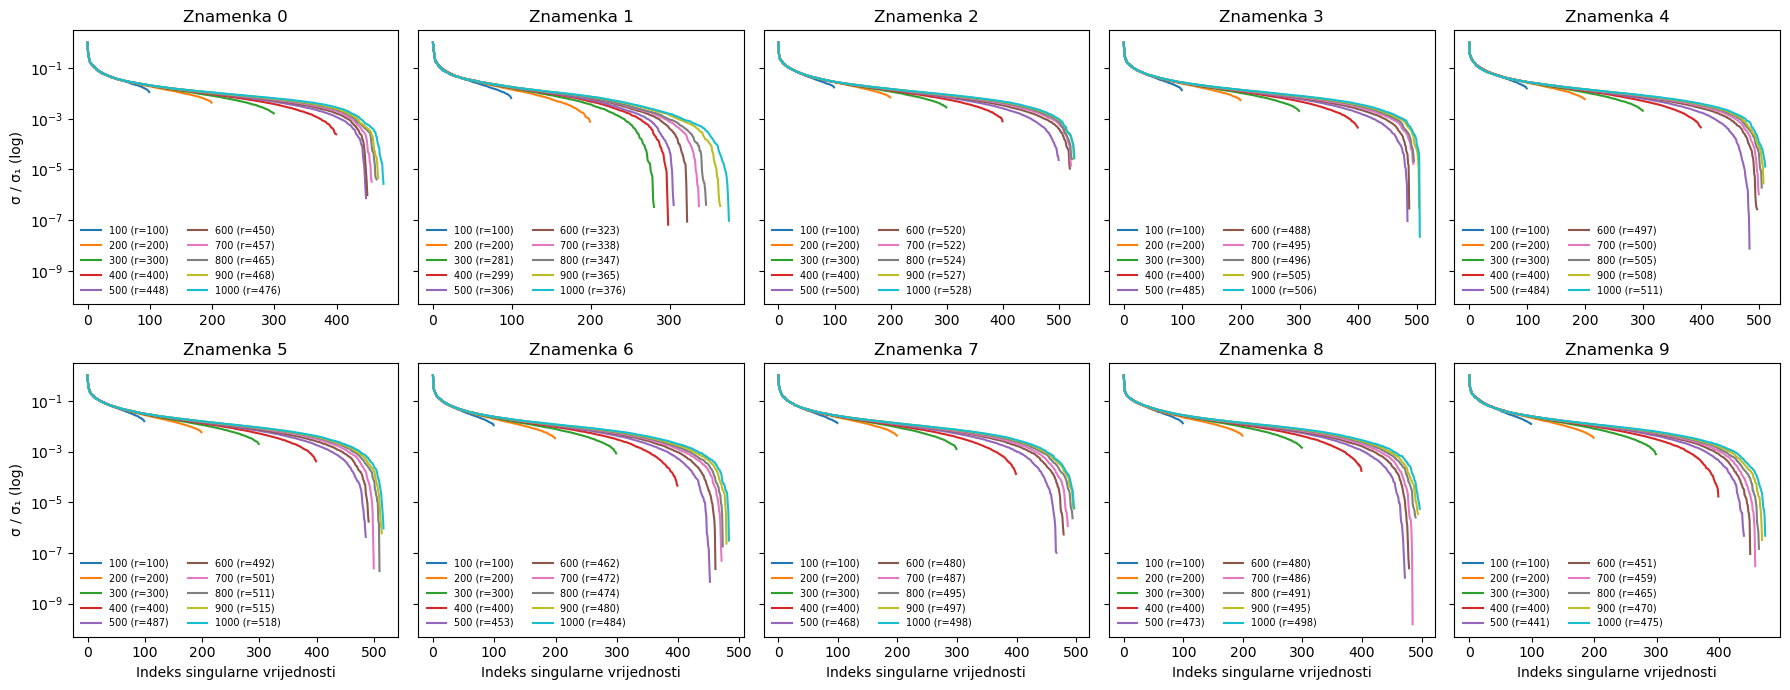

In [ ]:
# Odaberi listu veličina uzorka (izaberi jednu)
n_list = [100,200,300,400,500,600,700,800,900,1000]

def get_singular_values(images, n_samples):
    n = min(n_samples, len(images))
    if n == 0:
        return np.array([])
    A = images[:n].reshape(n, -1).T           # (784, n) 
    
    S = np.linalg.svd(A, full_matrices=False, compute_uv=False)
    return S

def numeric_rank(S):
    if S.size == 0:
        return 0
    tol = max(len(S), 1) * np.finfo(S.dtype).eps * (S[0] if S.size else 0.0)
    return int(np.sum(S > tol))

# Tablica rangova po znamenkama
rang_tablica = {d: [] for d in range(10)}

# --- Figura s mrežom 2×5 ---
rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(18, 7), sharey=True)
axes = axes.ravel()

for digit in range(10):
    ax = axes[digit]
    images_d = x_train[y_train == digit]

    for n in n_list:
        S = get_singular_values(images_d, n)
        if S.size == 0:
            continue
        r = numeric_rank(S)
        n_eff = min(n, len(images_d))
        rang_tablica[digit].append((n_eff, r))

        Sn = S / S[0]
        ax.plot(Sn[:r], label=f"{n_eff} (r={r})")

    ax.set_title(f"Znamenka {digit}")
    ax.set_yscale("log")
    if digit % cols == 0:
        ax.set_ylabel("σ / σ₁ (log)")
    if digit // cols == rows - 1:
        ax.set_xlabel("Indeks singularne vrijednosti")
    ax.legend(fontsize=7, ncol=2, frameon=False)

plt.tight_layout()
plt.show()


Nakon 150–200 komponenti krivulje idu prema 10^-3-10^-6 relativno na sigma1
→ Te komponente malo doprinose i često samo povećavaju rizik overfittinga.
1 ima najbrži pad i manji rang (jednostavniji oblik, manje intraklasne varijacije).
2, 3, 4, 5, 8 imaju sporiji pad/veći rang (više načina pisanja, zakrivljenosti).

Vizualizacija slika ovisno o uzetom rangu - redukcija dimenzionalnosti

In [172]:
def vizualiziraj_rekonstrukcije_r(x_train, y_train, k, r_list=(5, 10, 20, 30), *,
                                   seed=42, use_first=False, side=28,
                                   naslov="Redukcija dimenzionalnosti slike znamenke"):
    """
    Za svaku klasu: uzmi prvih k trening uzoraka (prema _napravi_indekse_po_klasi),
    napravi centrirani SVD, prikaži 1 original + rekonstrukcije za r u r_list.
    """
    klase = sorted(np.unique(y_train).astype(int))
    indeksi = _napravi_indekse_po_klasi(
        y_train, seed=seed, use_first=use_first,
        broj_klasa=int(np.max(y_train)) + 1
    )

    rows, cols = len(klase), 1 + len(r_list)
    fig, axes = plt.subplots(rows, cols, figsize=(2.2*cols, 2.2*rows))
    fig.suptitle(naslov, fontsize=14, y=0.985)  # naslov bliže gridu
    if rows == 1:
        axes = np.expand_dims(axes, 0)

    # naslovi stupaca
    axes[0, 0].set_title("original")
    for j, r in enumerate(r_list, start=1):
        axes[0, j].set_title(f"r={r}")

    for row, c in enumerate(klase):
        sel = indeksi[c][:k]
        if len(sel) == 0:
            for j in range(cols):
                axes[row, j].axis('off')
            continue

        # (dim, k) matrica, centriranje pa SVD
        A = x_train[sel].reshape(k, -1).T.astype(np.float32)
        mu = A.mean(axis=1, keepdims=True)
        Xc = A - mu
        U, s, _ = np.linalg.svd(Xc, full_matrices=False)

        # uzmi prvi primjer te klase
        x0 = x_train[sel[0]].reshape(-1).astype(np.float32)
        x0_disp = x0 / 255.0 if x0.max() > 1.0 else x0

        # original
        axes[row, 0].imshow(x0_disp.reshape(side, side), cmap="gray")
        axes[row, 0].set_ylabel(f"klasa {c}", rotation=90, va="center")

        # rekonstrukcije
        for j, r in enumerate(r_list, start=1):
            r_eff = min(r, U.shape[1])
            Ur = U[:, :r_eff]
            v = x0 - mu[:, 0]
            xr = mu[:, 0] + Ur @ (Ur.T @ v)
            xr_disp = xr / 255.0 if xr.max() > 1.0 else xr
            axes[row, j].imshow(xr_disp.reshape(side, side), cmap="gray")

        # bez osi
        for j in range(cols):
            axes[row, j].set_xticks([])
            axes[row, j].set_yticks([])

    # minimalni razmak od naslova (grid ide visoko)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


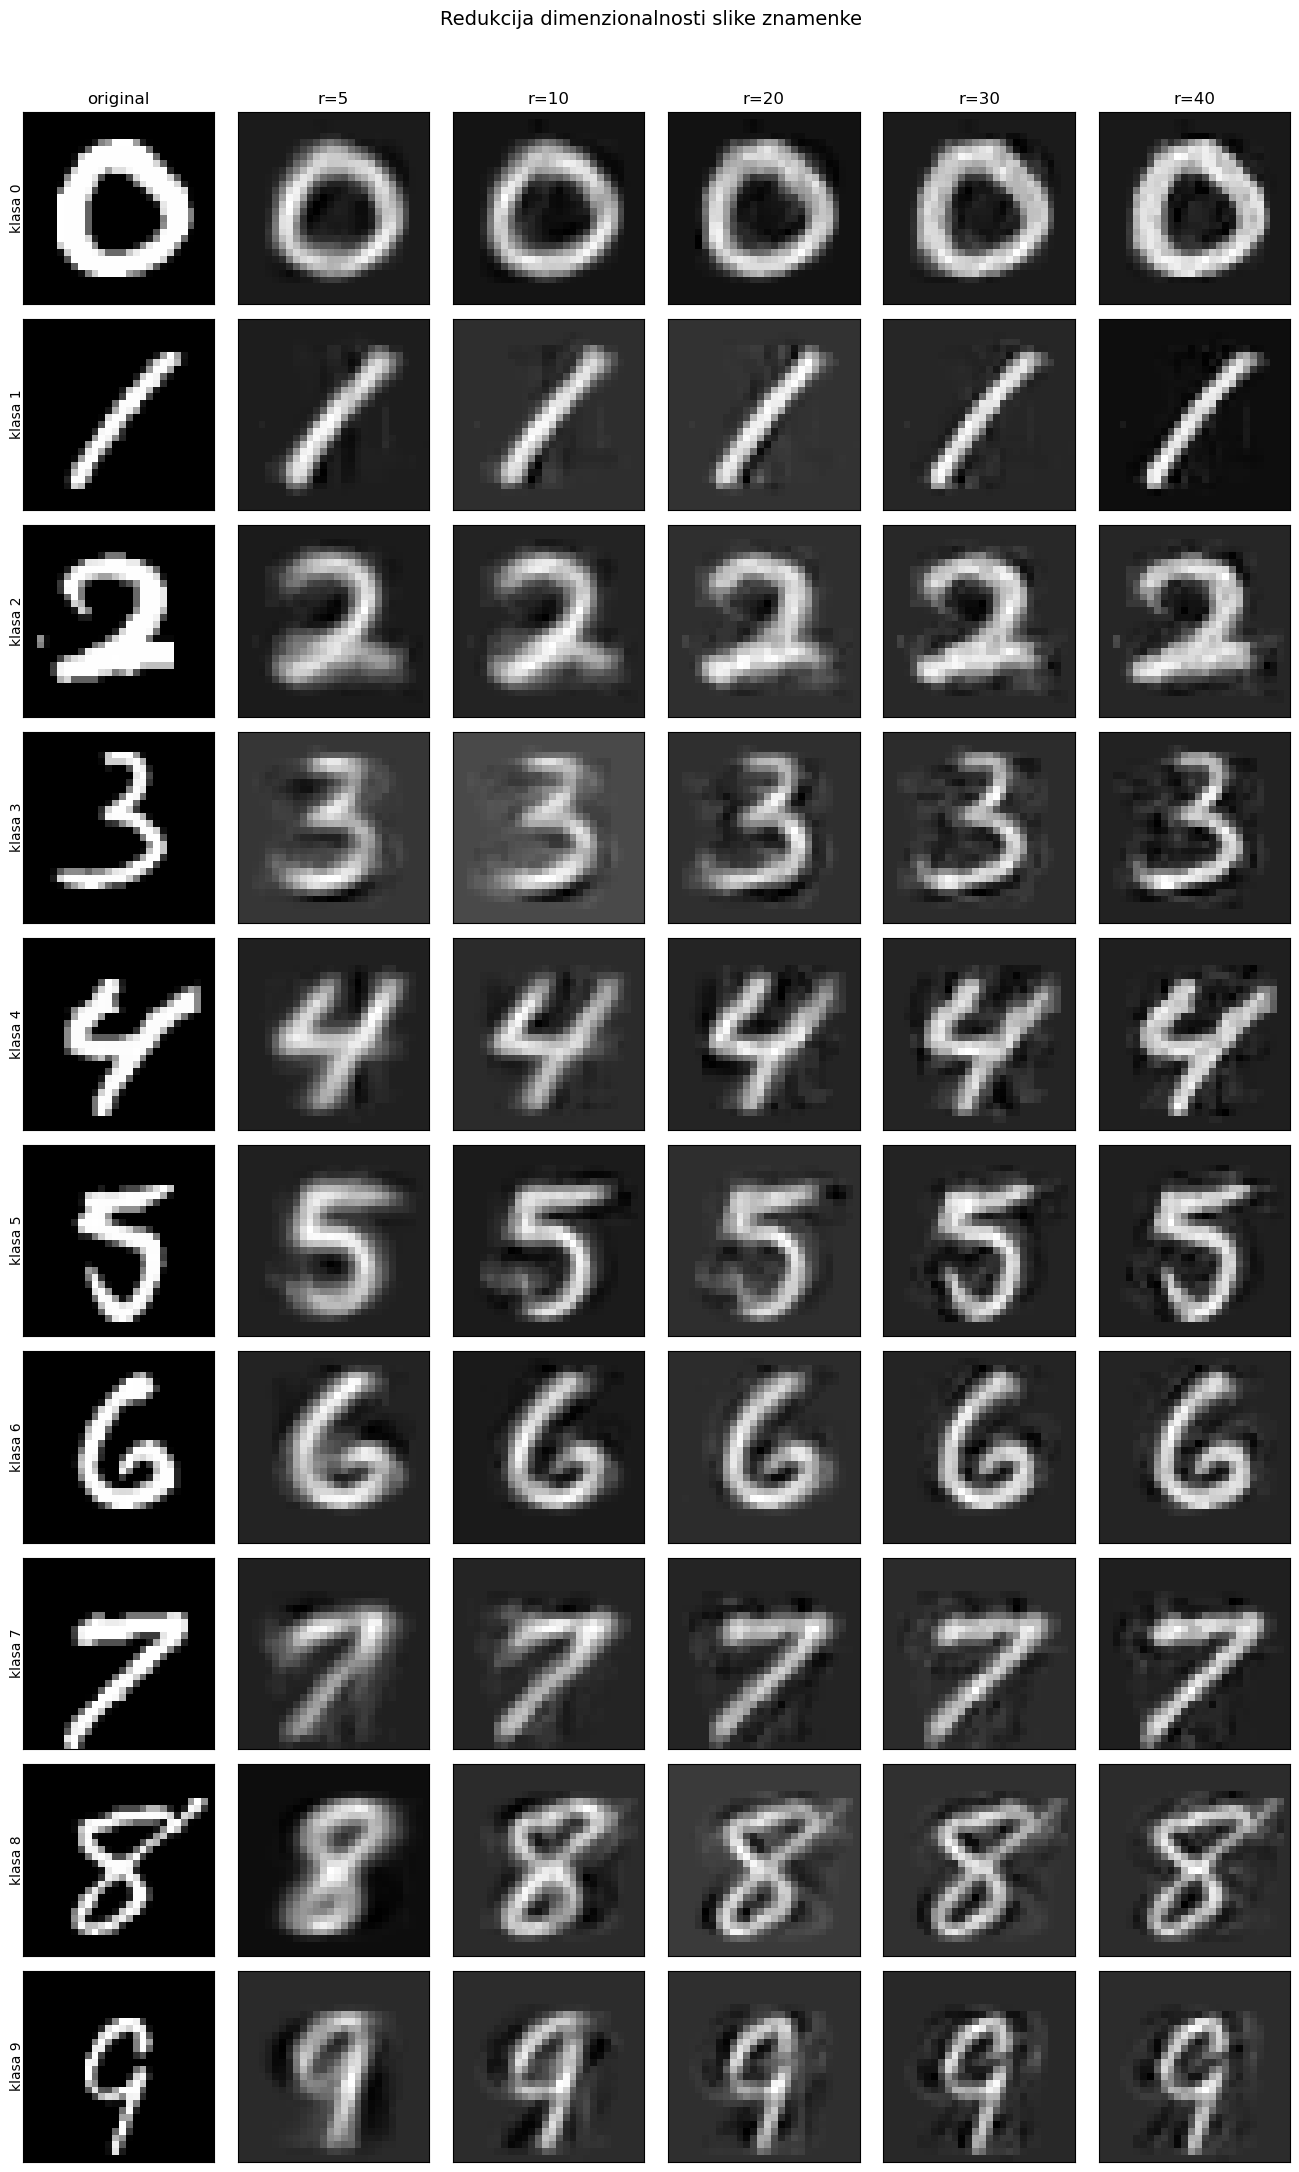

In [174]:
vizualiziraj_rekonstrukcije_r(
    x_train, y_train, k=k, r_list=[5, 10, 20, 30, 40],
    seed=42, use_first=False, side=28)


Kako ovdje sliku svodimo na nekoliko najznačajnijih smjerova varijacije (predstavimo je s 
𝑟 koeficijenata), tako se i na razini cijele matrice zadržavaju samo najsnažnije komponente — one povezane s najvećim singularnim vrijednostima — čime se čuva bitno, a ostatak odbacuje.

###  Određivanje projekcije na temelju kuta između projekcije i potprostora klasi znamenki

In [168]:
def predikcija_po_kutu(slika, baze):
    x = slika.reshape(-1).astype(np.float32)
    nx = np.linalg.norm(x)
    if nx < 1e-12:
        theta = np.pi / 2  # radijani
        theta = float(theta)
        return -1, theta

    najbolji_label, najmanji_kut = -1, np.inf  # najmanji_kut u radijanima
    for label, U in baze.items():
        proj = U @ (U.T @ x)
        c = np.linalg.norm(proj) / (nx + 1e-12)
        theta = float(np.arccos(np.clip(c, -1.0, 1.0)))  # radijani
        if theta < najmanji_kut:
            najmanji_kut = theta
            najbolji_label = label

    najmanji_kut = float(np.degrees(najmanji_kut))
    return najbolji_label, float(najmanji_kut)


### Evaluacija klasifikatora na test skupu

In [153]:
def _izracunaj_tocnost_prvihN(x_test, y_test, baze, N=500, zero_norm_policy="predict_neg1"):
    """Točnost na prvih N uzoraka (ili manje), s kontrolom nultih normi."""
    N_eval_cap = min(N, len(x_test))
    tocno = 0
    broj_eval = 0
    for i in range(N_eval_cap):
        x = x_test[i].reshape(-1).astype(np.float32)
        nx = np.linalg.norm(x)
        if nx < 1e-12:
            if zero_norm_policy == "skip":
                continue
            else:  # predict_neg1
                broj_eval += 1
                continue
        pred, _ = predikcija_po_kutu(x, baze)
        if pred == int(y_test[i]):
            tocno += 1
        broj_eval += 1
    if broj_eval == 0:
        return 0.0
    return tocno / broj_eval

In [154]:
def pregled_k_mnist_rel(x_train, y_train, x_test, y_test, *,
                        k_list, seed=123, N=500, use_first=False,
                        rel_tol=1e-2, zero_norm_policy="predict_neg1"):
    """
    Jedinstvena funkcija: za svaki k -> baze + točnost na prvih N testnih.
    Vraća: {k: {"acc": float, "ranks": {d:r_d}, "baze": dict}}
    """
    indeksi_po_klasi = _napravi_indekse_po_klasi(y_train, seed=seed, use_first=use_first)
    rezultati = {}
    for k in k_list:
        baze, rangovi = _izgradi_baze_za_k(x_train, indeksi_po_klasi, k, rel_tol=rel_tol)
        acc = _izracunaj_tocnost_prvihN(x_test, y_test, baze, N=N, zero_norm_policy=zero_norm_policy)
        rezultati[k] = {"acc": acc, "ranks": rangovi, "baze": baze}
    return rezultati

In [155]:
# -----------------------------
# 2) ISPIS: rangovi + točnost (kao "verbalna" varijanta)
# -----------------------------
def ispisi_rangove_i_tocnost(rezultati, N_eval_prikaz=None):
    """
    Lijep ispis po k: rangovi po klasama + točnost + prosj. rang.
    Ako je N_eval_prikaz zadan, koristi ga samo za tekstualni prikaz.
    """
    for k in sorted(rezultati.keys()):
        ranks = rezultati[k]["ranks"]
        acc = rezultati[k]["acc"]
        prosjek = float(np.mean(list(ranks.values())))
        print("Rangovi po klasama:", "  ".join(f"{d}:{r}" for d, r in sorted(ranks.items())))
        if N_eval_prikaz is not None:
            print(f"k={k:4d} | val točnost (na prvih {N_eval_prikaz}) = {acc*100:6.2f}% | prosj. rang = {prosjek:.1f}")
        else:
            print(f"k={k:4d} | val točnost = {acc*100:6.2f}% | prosj. rang = {prosjek:.1f}")
        print()

In [156]:
# -----------------------------
# 3) GRAF: točnost vs k + prosječni rang
# -----------------------------
def crtaj_rezultate_pregleda(rezultati, k_list=None, title="Točnost i prosječni rang vs. k"):
    if k_list is None:
        k_list = sorted(rezultati.keys())
    accs = [rezultati[k]["acc"] for k in k_list]
    avg_ranks = [np.mean(list(rezultati[k]["ranks"].values())) for k in k_list]

    fig, ax1 = plt.subplots(figsize=(7, 4))
    ax1.plot(k_list, accs, marker='o', label='Točnost')
    ax1.set_xlabel('Broj trening slika po klasi (k)')
    ax1.set_ylabel('Točnost')
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(k_list, avg_ranks, marker='s', linestyle='--', label='Prosječni rang', alpha=0.8)
    ax2.set_ylabel('Prosječni rang')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right')

    plt.title(title)
    plt.tight_layout()
    plt.show()


Rangovi po klasama: 0:10  1:10  2:10  3:10  4:10  5:10  6:10  7:10  8:10  9:10
k=  10 | val točnost (na prvih 1000) =  78.10% | prosj. rang = 10.0

Rangovi po klasama: 0:20  1:20  2:20  3:20  4:20  5:20  6:20  7:20  8:20  9:20
k=  20 | val točnost (na prvih 1000) =  83.90% | prosj. rang = 20.0

Rangovi po klasama: 0:30  1:30  2:30  3:30  4:30  5:30  6:30  7:30  8:30  9:30
k=  30 | val točnost (na prvih 1000) =  88.20% | prosj. rang = 30.0

Rangovi po klasama: 0:40  1:38  2:40  3:40  4:40  5:40  6:40  7:40  8:40  9:40
k=  40 | val točnost (na prvih 1000) =  88.40% | prosj. rang = 39.8

Rangovi po klasama: 0:49  1:40  2:50  3:50  4:50  5:50  6:48  7:50  8:50  9:49
k=  50 | val točnost (na prvih 1000) =  90.10% | prosj. rang = 48.6

Rangovi po klasama: 0:54  1:43  2:60  3:59  4:60  5:59  6:54  7:58  8:58  9:57
k=  60 | val točnost (na prvih 1000) =  90.80% | prosj. rang = 56.2

Rangovi po klasama: 0:57  1:47  2:69  3:65  4:67  5:68  6:56  7:63  8:64  9:61
k=  70 | val točnost (na prvih 10

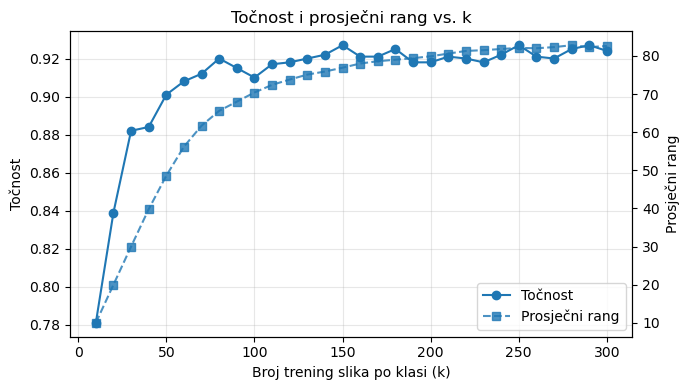

In [157]:
# --- PREGLED + GRAFOVI (dodaj na kraj, nakon dviju matrica konfuzije) ---
k_list = list(range(10, 301, 10))  # 10,20,...,300
rez = pregled_k_mnist_rel(
    x_train, y_train, x_test, y_test,
    k_list=k_list, seed=42, N=1000, use_first=False,
    rel_tol=3e-2, zero_norm_policy="predict_neg1"
)

# (po želji) ispis rangova i točnosti po k u konzolu:
ispisi_rangove_i_tocnost(rez, N_eval_prikaz=1000)

# graf: točnost i prosječni rang vs. k
crtaj_rezultate_pregleda(rez, k_list=k_list, title="Točnost i prosječni rang vs. k")


In [158]:
# -----------------------------
# 1a) KRATKI WRAPPER: napravi baze direktno iz train skupa za zadani k
# -----------------------------
def napravi_baze(x_train, y_train, k, *, seed=123, use_first=False, rel_tol=1e-2):
    """U jednom potezu vrati (baze, rangovi) za zadani k."""
    indeksi_po_klasi = _napravi_indekse_po_klasi(y_train, seed=seed, use_first=use_first)
    return _izgradi_baze_za_k(x_train, indeksi_po_klasi, k, rel_tol=rel_tol)


In [159]:
# -----------------------------
# 4) Evaluator s matricom konfuzije
# -----------------------------
def evaluiraj_kut(x, y, baze, crtaj_matricu=True):
    """
    x : (N, 28, 28)
    y : (N,)
    baze : dict[label] = U  (784, r)
    """
    y = np.asarray(y).astype(int)
    y_pred = np.array([int(predikcija_po_kutu(x[i].reshape(-1).astype(np.float32), baze)[0])
                       for i in range(len(x))])

    klase = sorted(set(map(int, np.unique(y))) | set(map(int, baze.keys())))
    K = len(klase)
    mapi = {c: i for i, c in enumerate(klase)}

    konf = np.zeros((K, K), dtype=int)
    for t, p in zip(y, y_pred):
        if t in mapi and p in mapi:
            konf[mapi[t], mapi[p]] += 1

    acc = (y_pred == y).mean()
    print(f"Ukupna točnost: {acc*100:.2f}%")

    print("\nTočnost po klasi:")
    for i, c in enumerate(klase):
        tot = konf[i, :].sum()
        tp = konf[i, i]
        if tot == 0:
            print(f"  Klasa {c}: n/a")
        else:
            print(f"  Klasa {c}: {tp/tot*100:.2f}%  ({tp}/{tot})")

    if crtaj_matricu:
        fig, ax = plt.subplots(figsize=(6, 5))
        im = ax.imshow(konf)
        ax.set_title("Matrica konfuzije")
        ax.set_xlabel("Predikcija")
        ax.set_ylabel("Stvarna klasa")
        ax.set_xticks(np.arange(K), labels=klase)
        ax.set_yticks(np.arange(K), labels=klase)
        for i in range(K):
            for j in range(K):
                v = konf[i, j]
                if v:
                    ax.text(j, i, str(v), ha="center", va="center")
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

    return acc, konf, klase, y_pred

Rangovi po klasama: 0:61  1:51  2:80  3:75  4:78  5:79  6:65  7:71  8:75  9:69

=== Nasumičnih 1000 testova ===
Ukupna točnost: 94.50%

Točnost po klasi:
  Klasa 0: 98.08%  (102/104)
  Klasa 1: 97.37%  (111/114)
  Klasa 2: 95.88%  (93/97)
  Klasa 3: 90.00%  (90/100)
  Klasa 4: 97.00%  (97/100)
  Klasa 5: 91.55%  (65/71)
  Klasa 6: 97.96%  (96/98)
  Klasa 7: 93.88%  (92/98)
  Klasa 8: 89.19%  (99/111)
  Klasa 9: 93.46%  (100/107)


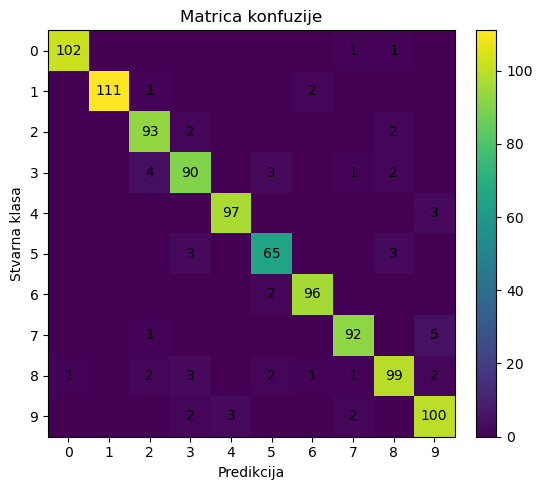


=== 1000 testova: 100 po svakoj znamenki ===
Ukupna točnost: 95.40%

Točnost po klasi:
  Klasa 0: 99.00%  (99/100)
  Klasa 1: 100.00%  (100/100)
  Klasa 2: 94.00%  (94/100)
  Klasa 3: 92.00%  (92/100)
  Klasa 4: 99.00%  (99/100)
  Klasa 5: 94.00%  (94/100)
  Klasa 6: 96.00%  (96/100)
  Klasa 7: 89.00%  (89/100)
  Klasa 8: 96.00%  (96/100)
  Klasa 9: 95.00%  (95/100)


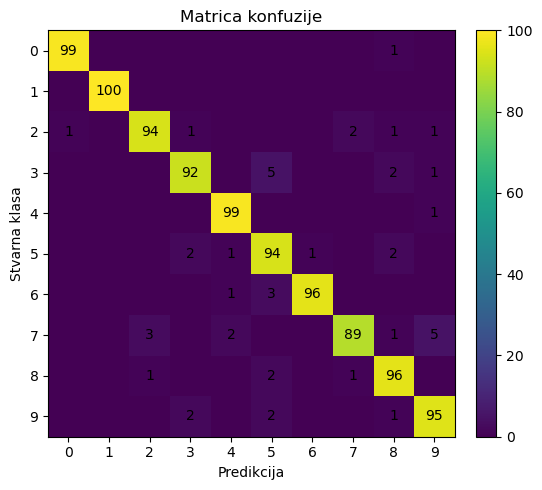

In [160]:
# =======================
# PRIMJERI POZIVA: dvije matrice konfuzije
# =======================
# Pretpostavlja se da već postoje: x_train, y_train, x_test, y_test (MNIST ili sl.)
# Napravi baze za odabrani k:
k = 100
baze, rangovi = napravi_baze(x_train, y_train, k=k, seed=42, use_first=False, rel_tol=3e-2)
print("Rangovi po klasama:", "  ".join(f"{d}:{r}" for d, r in sorted(rangovi.items())))

rng = np.random.default_rng(42)

# 1) Nasumičnih 1000 testova (bez ponavljanja)
n_rand = min(1000, len(y_test))
idx_rand = rng.choice(len(y_test), size=n_rand, replace=False)
print("\n=== Nasumičnih 1000 testova ===")
_ = evaluiraj_kut(x_test[idx_rand], y_test[idx_rand], baze, crtaj_matricu=True)

# 2) Točno 100 po klasi (ili najmanji zajednički broj ako neka klasa nema 100)
klase = sorted(map(int, np.unique(y_test)))
po_klasi = min(100, *[np.sum(y_test == c) for c in klase])
if po_klasi == 0:
    raise ValueError("Neka klasa nema niti jedan uzorak u testu.")
idx_po_klasi = [rng.choice(np.where(y_test == c)[0], size=po_klasi, replace=False) for c in klase]
idx_strat = np.concatenate(idx_po_klasi)
print(f"\n=== {po_klasi*len(klase)} testova: {po_klasi} po svakoj znamenki ===")
_ = evaluiraj_kut(x_test[idx_strat], y_test[idx_strat], baze, crtaj_matricu=True)

### Vizualizacija evaluiranih primjera

In [161]:
# ===========================
# BRZA EVAL + MREŽE PRIMJERA
# ===========================
N = 1000  # broj test primjera
N = min(N, len(x_test))

# 1) Iskoristi postojeću evaluaciju (bez crtanja matrice konfuzije)
tocnost, konf, klase, y_pred = evaluiraj_kut(x_test[:N], y_test[:N], baze, crtaj_matricu=False)
print(f"Točnost na {N} testnih slika: {tocnost*100:.2f}%")


Ukupna točnost: 91.00%

Točnost po klasi:
  Klasa 0: 95.29%  (81/85)
  Klasa 1: 99.21%  (125/126)
  Klasa 2: 88.79%  (103/116)
  Klasa 3: 88.79%  (95/107)
  Klasa 4: 93.64%  (103/110)
  Klasa 5: 83.91%  (73/87)
  Klasa 6: 91.95%  (80/87)
  Klasa 7: 84.85%  (84/99)
  Klasa 8: 86.52%  (77/89)
  Klasa 9: 94.68%  (89/94)
Točnost na 1000 testnih slika: 91.00%


In [162]:
# 2) Pomoćna funkcija za prikaz mreže (bez globalnih ovisnosti)
def prikazi_mrezu(indeksi, naslov, x, y, y_pred, redovi=5, stupci=10, figsize=(12, 6)):
    k = min(len(indeksi), redovi * stupci)
    if k == 0:
        print(f"(Nema primjera za prikaz: {naslov})")
        return
    fig, axs = plt.subplots(redovi, stupci, figsize=figsize)
    fig.suptitle(naslov, fontsize=16)
    axs = np.atleast_2d(axs)
    for j, ax in enumerate(axs.ravel()):
        ax.axis('off')
        if j < k:
            i = indeksi[j]
            ax.imshow(x[i], cmap='gray')
            ax.set_title(f"Stvarna: {int(y[i])}\nPredikcija: {int(y_pred[i])}")
    plt.tight_layout(rect=[0, 0, 1, 0.975])  # ostavi ~5% visine za naslov
    plt.show()

In [165]:
# Parametri prikaza/evaluacije
redovi = 4
stupci = 5
figsize = (12, 8)

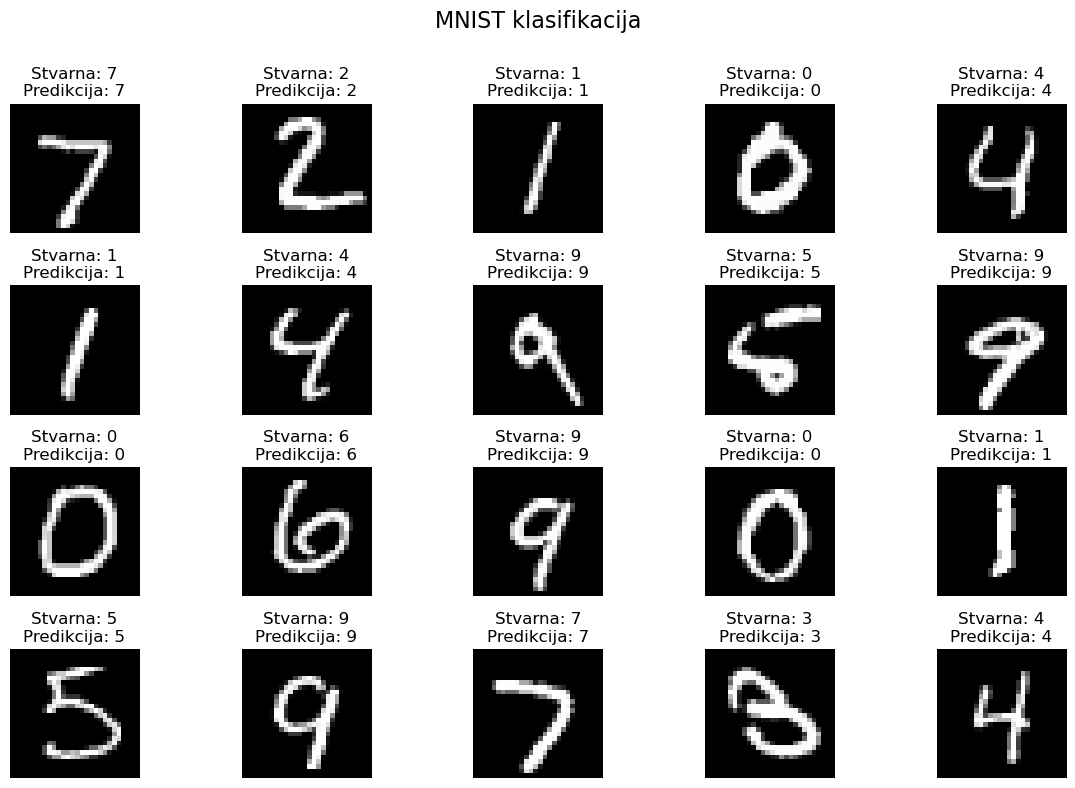

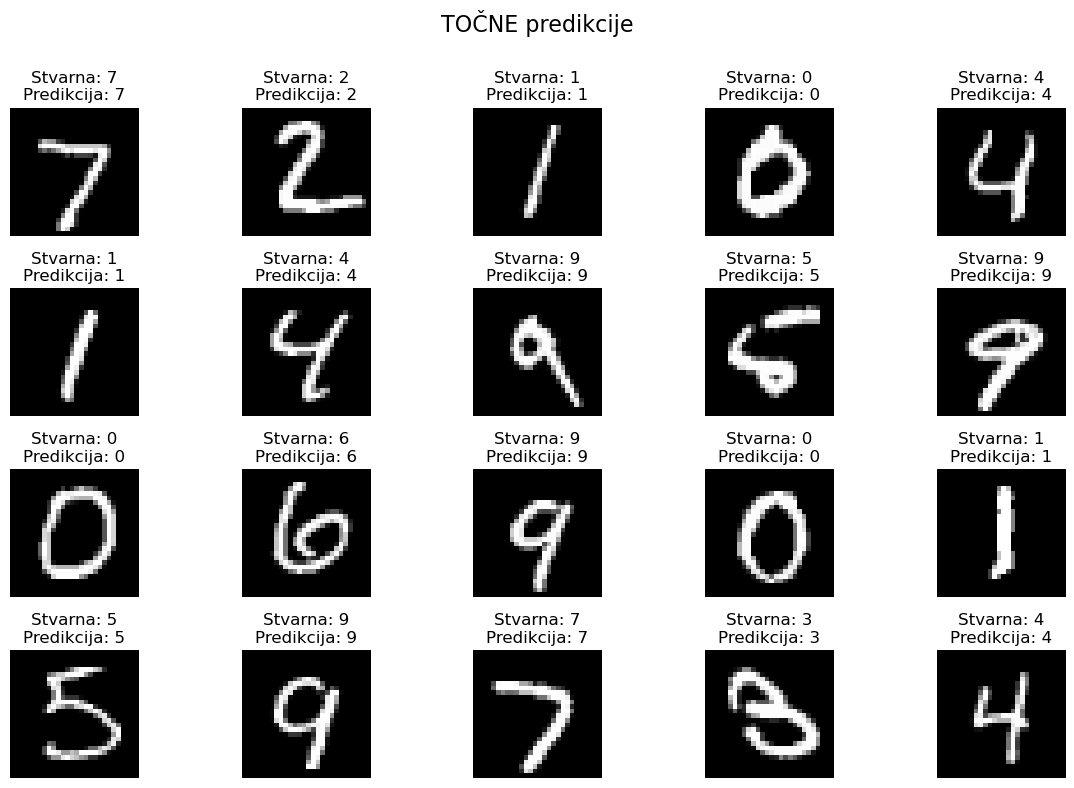

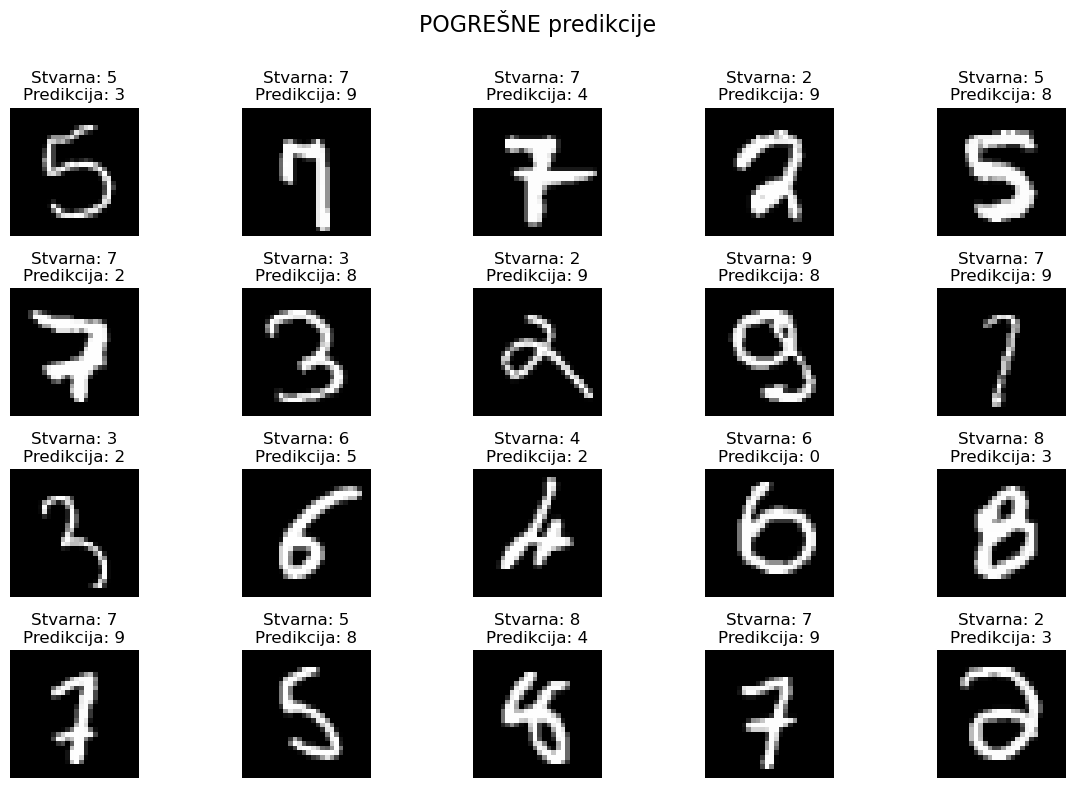

In [166]:
# 3) Skupovi indeksa
ind_svi = np.arange(min(N, redovi * stupci))
ind_tocni = np.where(y_pred == y_test[:N])[0]
ind_pogresni = np.where(y_pred != y_test[:N])[0]

# 4) Prikazi
prikazi_mrezu(ind_svi, "MNIST klasifikacija", x_test[:N], y_test[:N], y_pred, redovi, stupci, figsize)
prikazi_mrezu(ind_tocni, "TOČNE predikcije", x_test[:N], y_test[:N], y_pred, redovi, stupci, figsize)
prikazi_mrezu(ind_pogresni, "POGREŠNE predikcije", x_test[:N], y_test[:N], y_pred, redovi, stupci, figsize)

Više prikaza

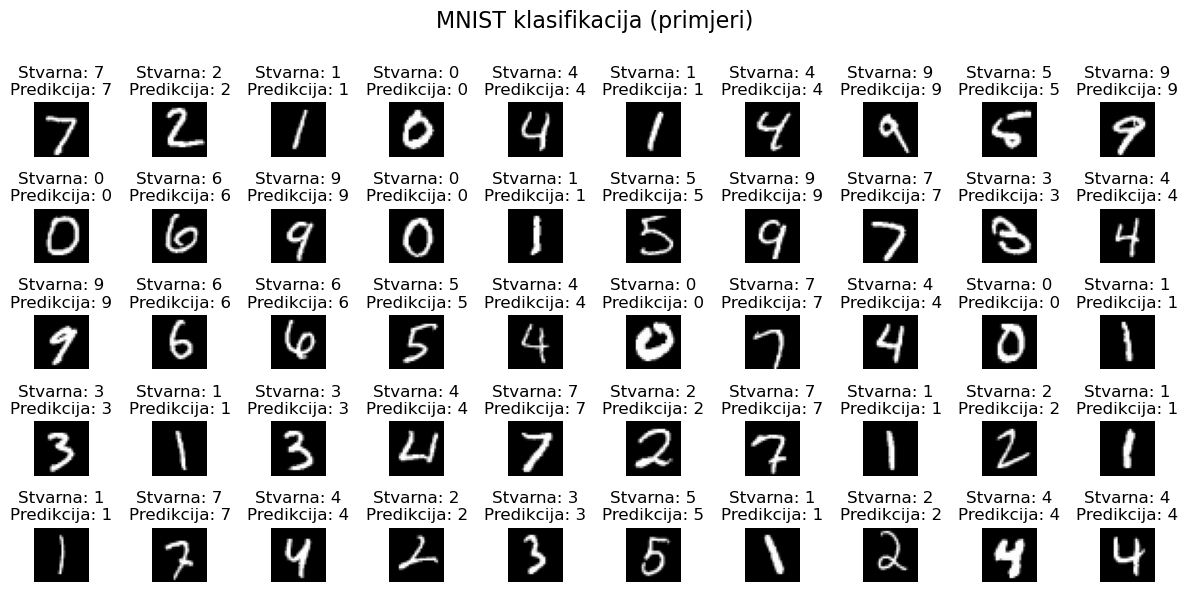

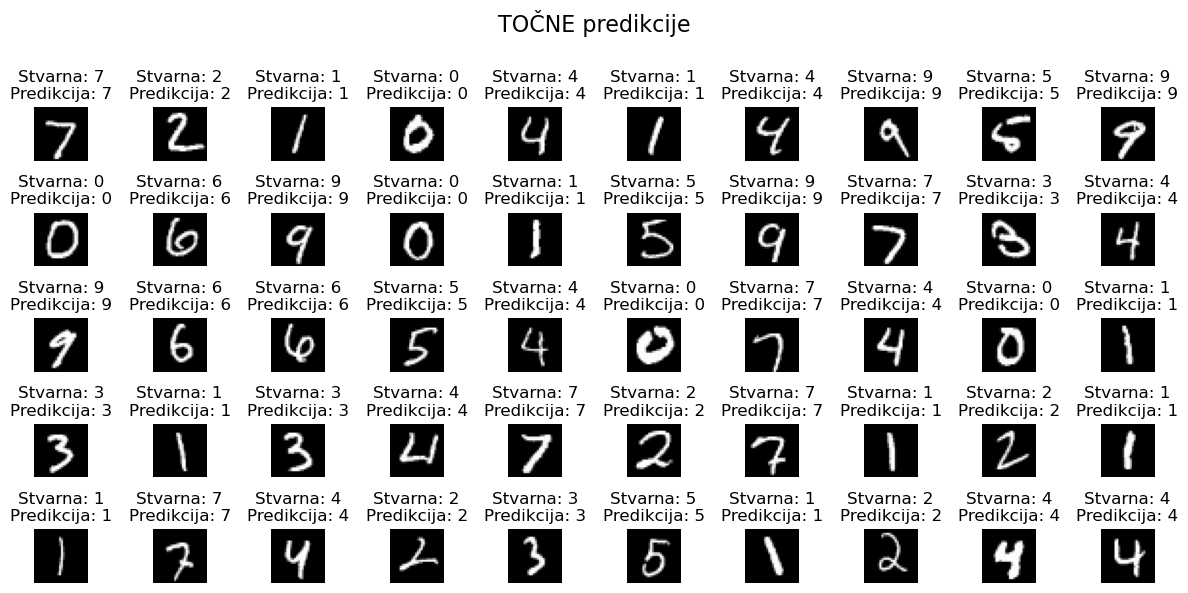

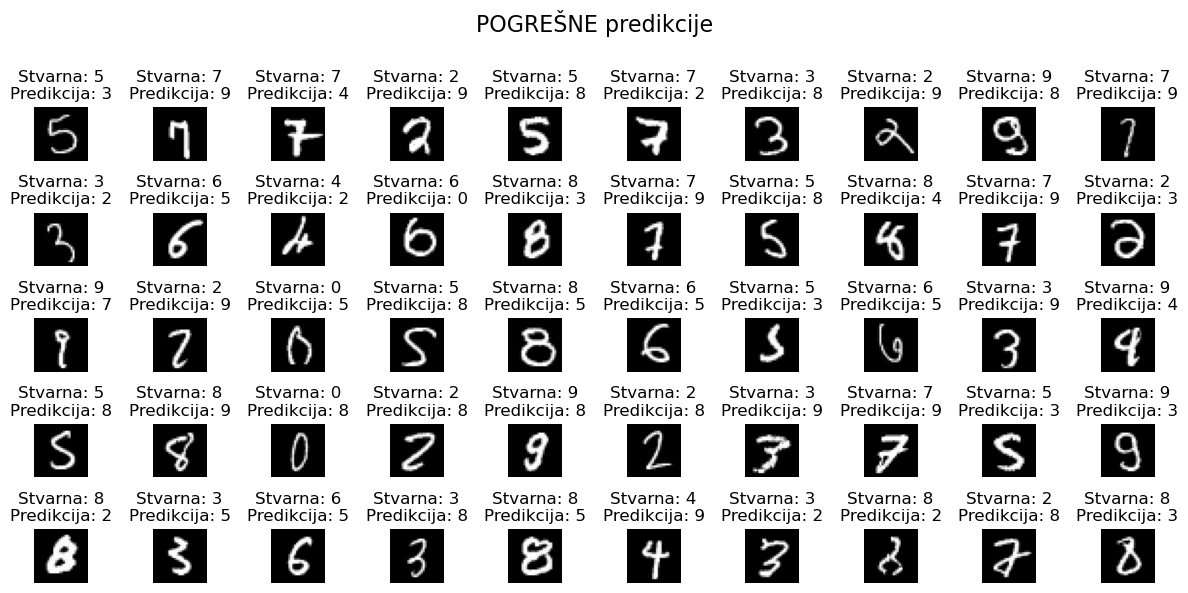

In [167]:
redovi, stupci = 5, 10
figsize = (12, 6)

ind_svi = np.arange(min(N, redovi * stupci))
ind_tocni = np.where(y_pred == y_test[:N])[0]
ind_pogresni = np.where(y_pred != y_test[:N])[0]

# 4) Prikazi
prikazi_mrezu(ind_svi, "MNIST klasifikacija (primjeri)", x_test[:N], y_test[:N], y_pred, redovi, stupci, figsize)
prikazi_mrezu(ind_tocni, "TOČNE predikcije", x_test[:N], y_test[:N], y_pred, redovi, stupci, figsize)
prikazi_mrezu(ind_pogresni, "POGREŠNE predikcije", x_test[:N], y_test[:N], y_pred, redovi, stupci, figsize)